In [254]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.artist as art
import seaborn as sns
#seaborn styling
sns.set(style="whitegrid")
import plotly.offline as pyo
import plotly.express as px
pyo.init_notebook_mode()

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [255]:
#acquire and clean data further
df = pd.read_csv("main_df.csv",low_memory=False)
df.category = np.where(df.item_group=="Court Time", "Admin",df.category)
df = df[df.category!="Program"]

#convert to timestamp
dft = df.copy()
dft.timestamp = pd.to_datetime(dft.timestamp)
dft.set_index("timestamp", inplace=True)

dft["day"] = dft.index.strftime("%w %a")
dft["year"] = dft.index.strftime("%Y")
dft["month"] = dft.index.strftime("%m %B")

In [256]:
#items
admin_items = list(df[df.category=="Admin"].item_group.unique())
bar_items = list(df[df.category=="Bar"].item_group.unique())
tennis_items = list(df[df.category=="Tennis"].item_group.unique())
fitness_items = list(df[df.category=="Fitness"].item_group.unique())
ps_items = list(df[df.category=="Pro Shop"].item_group.unique())
event_items = list(df[df.category=="Event"].item_group.unique())

## How to properly evaluate the data

1. Data was generated exclusively from Club Automation POS system. Because JNCC uses other POS system, the insights should not be assumed to mirror JNCC's revenue. However because the size of data is relatively large, the **trends and patterns likely reflect actual movements**.
  
  
2. Product category **Program** was excluded because payments are moved to RegFox, which is another POS system. Program category includes historical sales from the following:
     - Swim Lessons
     - Camp
     - Swim Camp
     - Kid Fit
     - Teen Performance Camp


3. The product categories and items included in the data are deliberately chosen to help forecast items that are currently offered by JNCC. An example of items removed from the analysis is Soccer club sales, which was previously in the Club Automation POS but had been moved to another POS system, separate from JNCC. Below is the list of item groups per product category.


In [257]:
item_group = pd.DataFrame(data=[admin_items,bar_items,tennis_items,fitness_items,ps_items,event_items],index=["Admin","Bar","Tennis","Fitness","Pro Shop","Events"]).fillna("").T

In [258]:
item_group.to_csv("item_group.csv",index=False)

## Outline

- I. Product Categories  
 - A. Trends & Seasonality
    1. Revenue and engagement as distinct KPIs
    2. Product categories and their corresponding trend
    3. Seasonalities in product categories
  - B. Forecasts
    1. Model Performance
    2. How to use 2020 Forecast Report

---

## A. Trends & Seasonality

### 1. Summary of Year-end Revenue

In [259]:
yearend_revenue = round(dft.pivot_table(values="total",columns="category",index="year",aggfunc=sum,margins=True),2)
yearend_revenue

category       Admin        Bar      Event    Fitness   Pro Shop      Tennis  \
year                                                                           
2015       458715.43   48245.24   17979.92   99960.68   38211.14   234886.66   
2016       485546.46   47185.83   30758.63  116796.00   44506.87   236021.52   
2017       554088.87   54714.70   20100.78  131726.00   26938.30   234418.52   
2018       651830.42   98097.53   24667.37  100659.00   30354.17   257563.59   
2019       688293.92  141798.75   35970.59  105767.40   28216.38   284344.43   
All       2838475.10  390042.05  129477.29  554909.08  168226.86  1247234.72   

category         All  
year                  
2015       897999.07  
2016       960815.31  
2017      1021987.17  
2018      1163172.08  
2019      1284391.47  
All       5328365.10

### 2. Summary of Year-end Engagement

In [260]:
yearend_engagement = round(dft.pivot_table(values="trans_id",columns="category",index="year",aggfunc="count",margins=True),2)
yearend_engagement

category  Admin    Bar  Event  Fitness  Pro Shop  Tennis     All
year                                                            
2015       3167  11426    863     1803      1479    4685   23423
2016       3402   9404    878     1834      1388    4965   21871
2017       4013  10820    812     2125      1199    4844   23813
2018       6659  17764    673     1885      1213    4537   32731
2019       7709  22435    977     2079      1132    4737   39069
All       24950  71849   4203     9726      6411   23768  140907

In [261]:
to = dft[dft.category == "Tennis"]

In [262]:
to.shape

(23768, 16)

In [263]:
to_summary = to.groupby("year").agg({"total":"sum","trans_id":"count"}).rename(columns={"total":"revenue","trans_id":"engagement"})

In [264]:
to_summary

revenue  engagement
year                       
2015  234886.66        4685
2016  236021.52        4965
2017  234418.52        4844
2018  257563.59        4537
2019  284344.43        4737

In [265]:
rev_eng = dft.groupby(["category"]).resample("6M").agg({"total":sum,"trans_id":"count"}).reset_index().rename(columns={"total":"dollar_value","trans_id":"frequency"})

In [266]:
rev_eng["dollar_value_scaled"] = MinMaxScaler().fit_transform(rev_eng[["dollar_value","frequency"]])[:,0]
rev_eng["frequency_scaled"] = MinMaxScaler().fit_transform(rev_eng[["dollar_value","frequency"]])[:,1]

In [267]:
rev_eng.timestamp = rev_eng.timestamp.dt.strftime("%b-%y")
rev_eng.set_index("timestamp",inplace=True)

In [268]:
def plot_axis(ax,cat,df,s1,s2,c1="steelblue",c2="tomato",xmax=11,lw=1):
    ax.plot(df[s1][df["category"]==cat],color="#328B9B",lw=lw,label="revenue")
    ax.plot(df[s2][df["category"]==cat],color="#7FB13F",lw=lw,label="engagement")
    ax.get_yaxis().set_visible(False)
    ax.set_title(cat)
#     ax.hlines(y=0,xmin=0,xmax=xmax,ls=":",color="black")

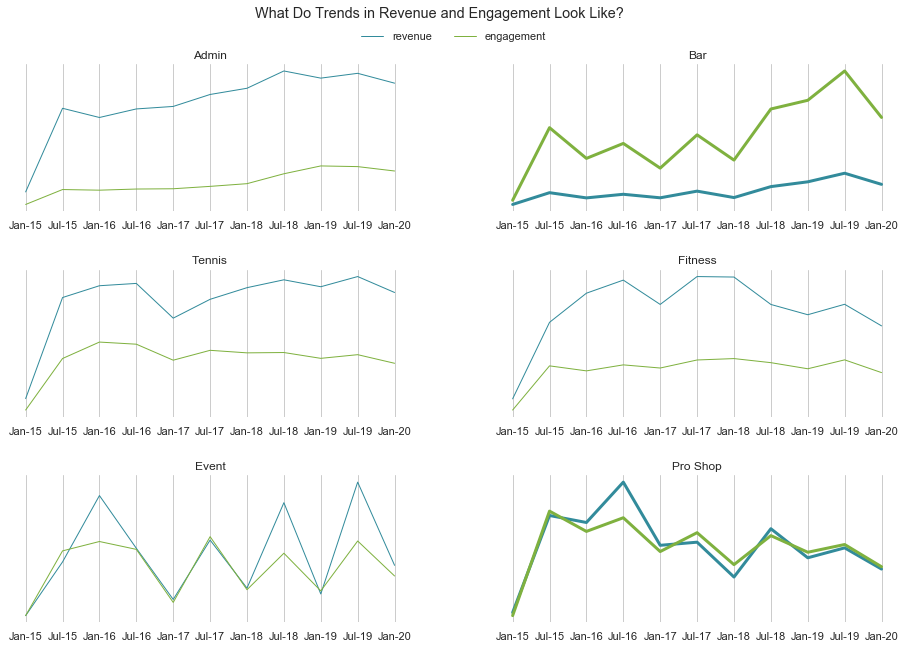

In [269]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("What Do Trends in Revenue and Engagement Look Like?")

ax1 = fig.add_subplot(321,frameon=False)
ax2 = fig.add_subplot(322,frameon=False)
ax3 = fig.add_subplot(323,frameon=False)
ax4 = fig.add_subplot(324,frameon=False)
ax5 = fig.add_subplot(325,frameon=False)
ax6 = fig.add_subplot(326,frameon=False)

plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)

plot_axis(ax1,"Admin",rev_eng,"dollar_value_scaled","frequency_scaled",xmax=10)
sub1 = plot_axis(ax2,"Bar",rev_eng,"dollar_value_scaled","frequency_scaled",xmax=10,lw=3)
plot_axis(ax3,"Tennis",rev_eng,"dollar_value_scaled","frequency_scaled",xmax=10)
plot_axis(ax4,"Fitness",rev_eng,"dollar_value_scaled","frequency_scaled",xmax=10)
plot_axis(ax5,"Event",rev_eng,"dollar_value_scaled","frequency_scaled",xmax=10)
sub3 = plot_axis(ax6,"Pro Shop",rev_eng,"dollar_value_scaled","frequency_scaled",xmax=10,lw=3)

fig.legend([sub1],labels=["revenue","engagement"],loc='upper center', ncol=2, borderaxespad=2.5, frameon=False)
plt.subplots_adjust(hspace=0.4)
plt.show()

What: **Scaled representation of Revenue and Engagement**
 - If the engagement and revenue are proportionate to each other, the red line (engagement) sits just below the blue line (revenue) and follows roughly the same movement.  
  
So What: **Revenue and Engagement in Bar is oppositely proportionate, and in Pro Shop is disroportionate**.
 - Bar: While the engagement touchpoints are high (customers buy frequently), the items are priced relatively lower. 
 - Pro Shop: The engagement touchpoints are not generating desired revenue. This pattern likely happens when revenue is highly affected by an abnormally-high or abnormally low-priced item. In other words the variance of prices is big. Maybe only certain Pro Shop goods are driving revenue, but everything else are not revenue-generating.
 > Looking at the Pro Shop items further, we see the following:  
     - Racquets are generating high revenue but at a lower frequency
     - Shoe and apparel are adequately priced and follow the ~1:2 ratio (engagement:revenue)
     - The rest are low priced items that generating visible (but low) revenue because of the amount of items purchased.

In [274]:
ps = df[df.category=="Pro Shop"]
ps = ps.groupby("item_group").agg({"total":sum,"trans_id":"count"}).rename(columns={"total":"revenue","trans_id":"no_transactions"}).reset_index()

In [276]:
ps.to_csv("proshop_summary.csv",index=False)

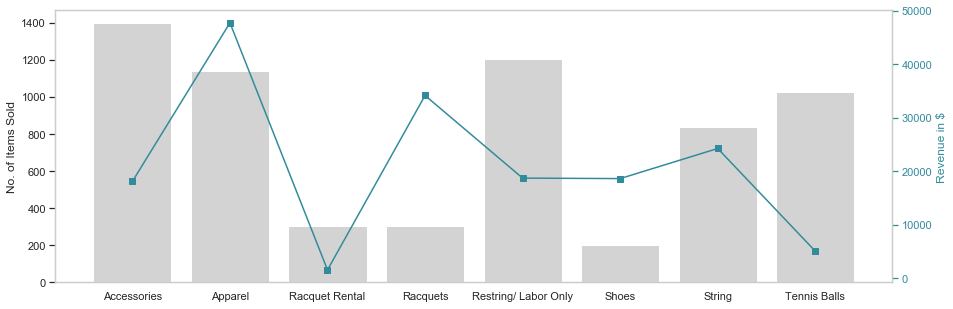

In [271]:
fig, ax1 = plt.subplots(figsize=(15,5))

lab1 = ax1.bar(x=ps.item_group,height=ps.no_transactions,color="lightgray",label="number of transactions")
ax1.grid(False)
ax1.set_ylabel("No. of Items Sold")

ax2 = ax1.twinx()
lab2 = ax2.plot(ps.revenue,color="#328B9B",marker="s",label="revenue")
ax2.set_ylabel('', color='#328B9B')
ax2.tick_params('y', colors='#328B9B')
ax2.grid(False)
ax2.set_ylabel("Revenue in $")


# plt.suptitle("How Does Engagement and Revenue Compare in Various Pro Shop Items?")
# plt.legend((lab1,lab2),("y","z"),loc='upper center', ncol=1, borderaxespad=0, facecolor="inherit", frameon=False)
plt.show()

### 3. Decomposing Trends

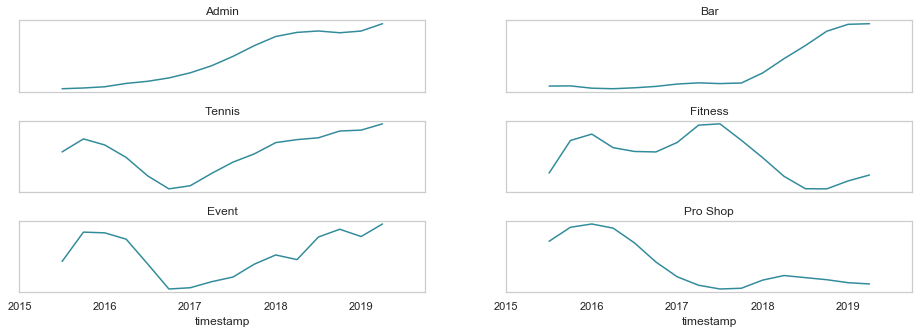

In [18]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

categories = {"Admin":ax1,"Bar":ax2,"Tennis":ax3,"Fitness":ax4,"Event":ax5,"Pro Shop":ax6}

for c,axis in categories.items():
    decomposition_rev = sm.tsa.seasonal_decompose(dft[dft["category"]==c]["total"].resample('Q').sum(), model='additive')
    trend_rev = decomposition_rev.trend
    trend_rev.plot(ax=axis, title=f"{c}",color="#328B9B")
    if (c == "Event") or (c == "Pro Shop"):
        axis.get_xaxis().set_visible(True)
        axis.get_yaxis().set_visible(False)
        axis.grid(False)
    else:
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
        
plt.subplots_adjust(hspace=0.4)
# plt.savefig('graph/trend_rev.png', transparent=True)

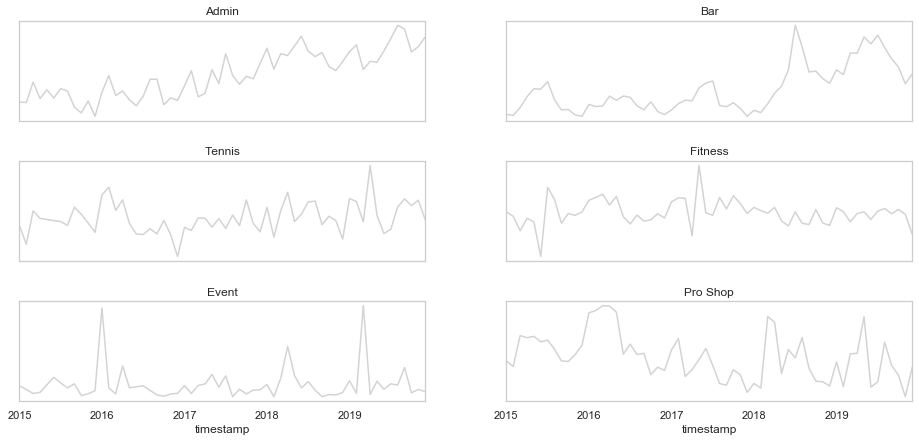

In [19]:
fig = plt.figure(figsize=(16,7))

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

categories = {"Admin":ax1,"Bar":ax2,"Tennis":ax3,"Fitness":ax4,"Event":ax5,"Pro Shop":ax6}

for c,axis in categories.items():
    decomposition_rev = sm.tsa.seasonal_decompose(dft[dft["category"]==c]["total"].resample('MS').sum(), model='additive')
    trend_rev = decomposition_rev.observed
    trend_rev.plot(ax=axis, title=f"{c}",color="lightgray")
    if (c == "Event") or (c == "Pro Shop"):
        axis.get_xaxis().set_visible(True)
        axis.get_yaxis().set_visible(False)
        axis.grid(False)
    else:
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
        
plt.subplots_adjust(hspace=0.4)
# plt.savefig('graph/trend_obs.png', transparent=True)

What: **Trend Decomposition**
 - When we remove the residual and seasonality, these are the trends per product category. In the above chart, we see smooth trend movements.
  
So What: **Some categories are in an uptrend, others are in downtrend**
 - Uptrend
     - Admin
     - Bar
     - Tennis
     - Event
 - Downtrend
     - Fitness
     - Pro Shop
 - Discernible changepoints happened towards the latter part of 2016 that caused `Tennis` and `Event` to dip but a trend reversal shortly followed.
 - `Bar` sales continue to rise especially when Naturally opened in the middle of 2018.
 - `Fitness` sales peaked in in the middle of 2017 but in a rapid fall thereon.
 - `Pro Shop` has not seen any growth since 2016.

### 4. Decomposing Seasonality

#### Decomposition of Seasonality

In [240]:
seas = dft.copy()
seas.index = pd.to_datetime(seas.index)

In [241]:
seas

acn  trans_id  \
timestamp                             
2015-08-12 16:03:00    11     37777   
2015-08-21 08:02:00    11     38361   
2015-08-21 08:02:00    11     38360   
2015-07-24 11:53:00    11     35130   
2015-07-24 11:53:00    11     35131   
2015-07-24 11:53:00    11     35132   
2015-07-24 11:53:00    11     35139   
2015-07-24 11:53:00    11     35138   
2015-07-24 11:53:00    11     35137   
2015-07-24 11:53:00    11     35136   
2015-07-24 11:53:00    11     35135   
2015-07-24 11:53:00    11     35134   
2015-07-24 11:53:00    11     35133   
2015-11-23 08:38:00    11     50622   
2015-11-14 12:32:00    11     49262   
2015-12-17 13:56:00    11     52993   
2015-12-02 10:09:00    11     51773   
2015-12-12 07:57:00    11     52556   
2015-12-14 15:38:00    11     52704   
2015-12-15 15:47:00    11     52803   
2015-09-10 15:07:00    11     41721   
2015-09-10 15:07:00    11     41720   
2015-10-09 11:05:00    11     44946   
2015-03-27 21:52:00    11     17456   
2015-03-23 13:13:00    11     17047   
2015-03-17 09:44:00    11     16691   
2015-04-17 09:05:00    11     20085   
2015-04-12 16:27:00    11     19657   
2015-04-23 17:01:00    11     21141   
2015-04-21 15:42:00    11     20935   
...                   ...       ...   
2019-12-17 09:32:00  5387    243095   
2019-12-08 12:45:00  5388    242256   
2019-12-04 18:24:00  5391    241933   
2019-12-04 18:22:00  5392    241932   
2019-12-30 19:38:00  5396    244019   
2019-12-30 20:06:00  5396    244026   
2019-12-30 20:09:00  5396    244027   
2019-12-30 20:12:00  5396    244028   
2019-12-30 19:19:00  5396    244008   
2019-12-30 19:19:00  5396    244009   
2019-12-28 16:05:00  5396    243783   
2019-12-28 16:05:00  5396    243782   
2019-12-28 15:30:00  5396    243775   
2019-12-28 15:30:00  5396    243776   
2019-12-28 15:30:00  5396    243777   
2019-12-31 00:00:00  5396    244448   
2019-12-10 14:19:00  5396    242489   
2019-12-10 14:19:00  5396    242488   
2019-12-09 20:45:00  5397    242429   
2019-12-17 17:04:00  5424    243138   
2019-12-28 13:28:00  5425    243751   
2019-12-28 13:28:00  5425    243752   
2019-12-28 13:40:00  5425    243753   
2019-12-28 13:40:00  5425    243754   
2019-12-28 13:43:00  5425    243758   
2019-12-31 00:00:00  5425    244449   
2019-12-20 11:18:00  5425    243309   
2019-12-20 11:18:00  5425    243310   
2019-12-27 15:50:00  5428    243695   
2019-12-31 00:00:00  5428    244450   

                                                                  item  \
timestamp                                                                
2015-08-12 16:03:00                                         Core Power   
2015-08-21 08:02:00                                      Berries Amore   
2015-08-21 08:02:00                                    Smoothie Add-On   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-11-23 08:38:00                                          CLIFF BAR   
2015-11-14 12:32:00                                         Core Power   
2015-12-17 13:56:00                                      Berries Amore   
2015-12-02 10:09:00                                      Berries Amore   
2015-12-12 07:57:00                                         Core Power   
2015-12-14 15:38:00                                      Berries Amore   
2015-12-15

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

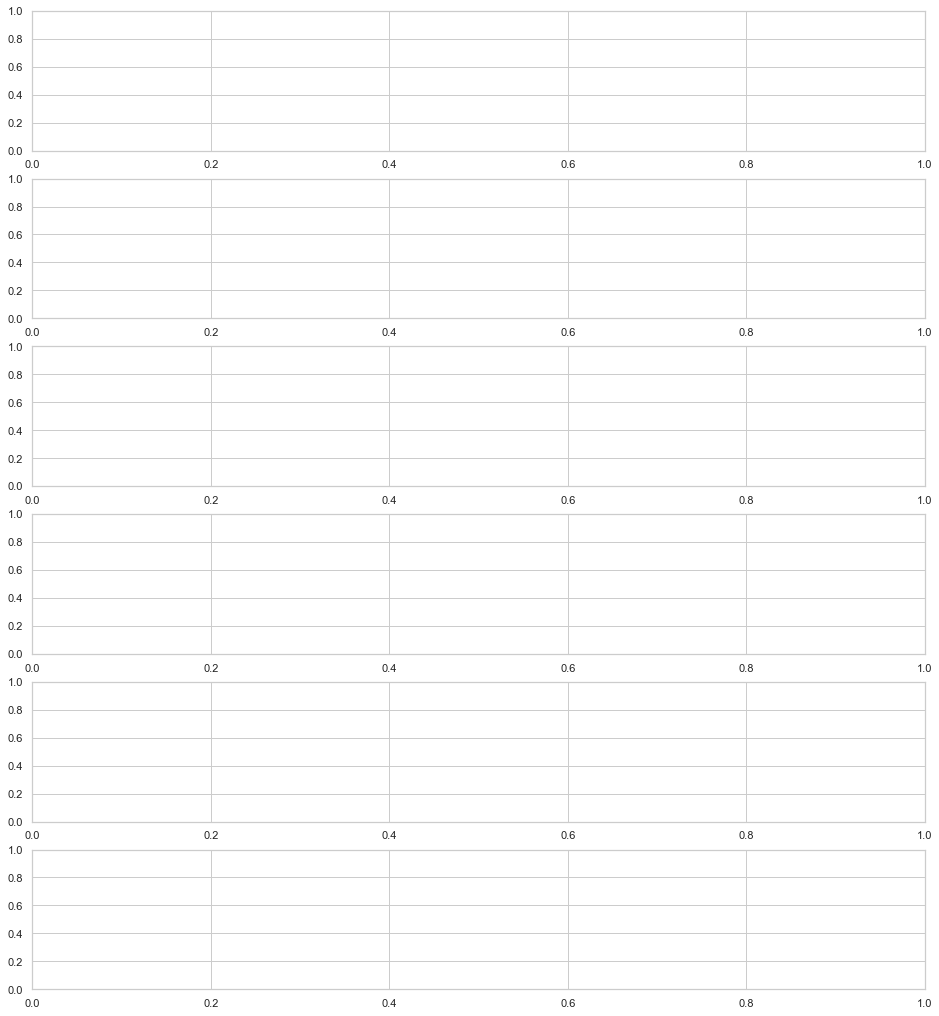

In [243]:
fig = plt.figure(figsize=(16,18))

ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)
ax4 = fig.add_subplot(614)
ax5 = fig.add_subplot(615)
ax6 = fig.add_subplot(616)

categories = {"Admin":ax1,"Bar":ax2,"Tennis":ax3,"Fitness":ax4,"Event":ax5,"Pro Shop":ax6}

seas = dft.copy()
seas.index = pd.to_datetime(seas.index)

for c,axis in categories.items():
    decomposition = sm.tsa.seasonal_decompose(seas[seas.category==c].resample(Q), model='additive')    
    seasons = decomposition.seasonal
    seasons.plot(ax=axis, title=f"{c}",color="#328B9B")
    axis.grid(False)
        
fig.subplots_adjust(hspace=3)
# plt.savefig('graph/seasonality_rev.png', transparent=True)

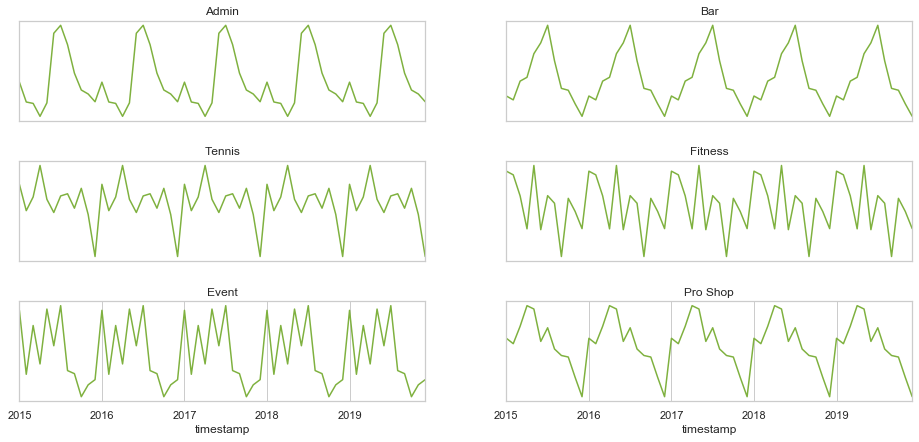

In [193]:
fig = plt.figure(figsize=(16,7))

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

categories = {"Admin":ax1,"Bar":ax2,"Tennis":ax3,"Fitness":ax4,"Event":ax5,"Pro Shop":ax6}

for c,axis in categories.items():
    decomposition = sm.tsa.seasonal_decompose(dft[dft["category"]==c]["trans_id"].resample('MS').count(), model='additive')    
    seasons = decomposition.seasonal
    seasons.plot(ax=axis, title=f"{c}",color="#7FB13F")
    if (c == "Event") or (c == "Pro Shop"):
        axis.get_yaxis().set_visible(False)
        axis.grid(True)
    else:
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
        axis.grid(True)
        
fig.subplots_adjust(hspace=0.4)
# plt.savefig('graph/seasonality_eng.png', transparent=True)

#### Auto Correlation and Seasonality

In [22]:
admin_monthly = dft[dft.category=="Admin"].resample("MS")[["total"]].sum()
bar_monthly = dft[dft.category=="Bar"].resample("MS")[["total"]].sum()
tennis_monthly = dft[dft.category=="Tennis"].resample("MS")[["total"]].sum()
fitness_monthly = dft[dft.category=="Fitness"].resample("MS")[["total"]].sum()
event_monthly = dft[dft.category=="Event"].resample("MS")[["total"]].sum()
ps_monthly = dft[dft.category=="Pro Shop"].resample("MS")[["total"]].sum()

In [23]:
acf_dfs = [admin_monthly,bar_monthly,tennis_monthly,fitness_monthly,event_monthly,ps_monthly]
pc = ["Admin","Bar","Tennis","Fitness","Event","Pro Shop"]

In [24]:
# from statsmodels.tsa.stattools import acf, pacf
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# fig, axs = plt.subplots(6,1,figsize=(16,25), dpi= 100)

# for index,subset in enumerate(acf_dfs):
#     plot_acf(subset["total"].tolist(), lags=54, ax=axs[index])
#     axs[index].spines['top'].set_visible(False)
#     axs[index].spines['right'].set_visible(False)
#     axs[index].spines['bottom'].set_visible(False)
#     axs[index].spines['left'].set_visible(False)

# for index,cat in enumerate(pc):
#     axs[index].set_title(cat)


# plt.subplots_adjust(hspace=0.4)

Daily Seasonality

In [110]:
daily_eng = dft.pivot_table(columns="category",index="day",values="total",aggfunc="count").reset_index()

In [111]:
daily_eng

category    day  Admin    Bar  Event  Fitness  Pro Shop  Tennis
0         0 Sun   3258   5667    242      194       429     398
1         1 Mon   3237  13240   1100     1611      1047    4169
2         2 Tue   3784  10294    235     1605      1100    4696
3         3 Wed   3243  10177    226     2111      1002    4829
4         4 Thu   4112  10744    658     1631      1011    3493
5         5 Fri   3192   9453    538     2338       923    2880
6         6 Sat   4124  12274   1204      236       899    3303

In [112]:
daily_rev = dft.pivot_table(columns="category",index="day",values="total",aggfunc="sum").reset_index()
daily_rev

category    day      Admin       Bar     Event    Fitness  Pro Shop     Tennis
0         0 Sun  340455.08  31934.44  11829.91   10790.50   8884.64   42388.53
1         1 Mon  400504.66  66921.92  34071.54  102718.30  26019.07  217000.16
2         2 Tue  440337.88  59367.95  15702.53   84039.30  33789.91  251599.48
3         3 Wed  394211.11  55213.94  10732.12  121394.38  27202.20  240913.83
4         4 Thu  462306.16  60661.23  15025.60   92668.80  25245.69  202184.52
5         5 Fri  352354.67  51391.67  14209.03  126268.80  24892.75  164477.63
6         6 Sat  448305.54  64550.90  27906.56   17029.00  22192.60  128670.57

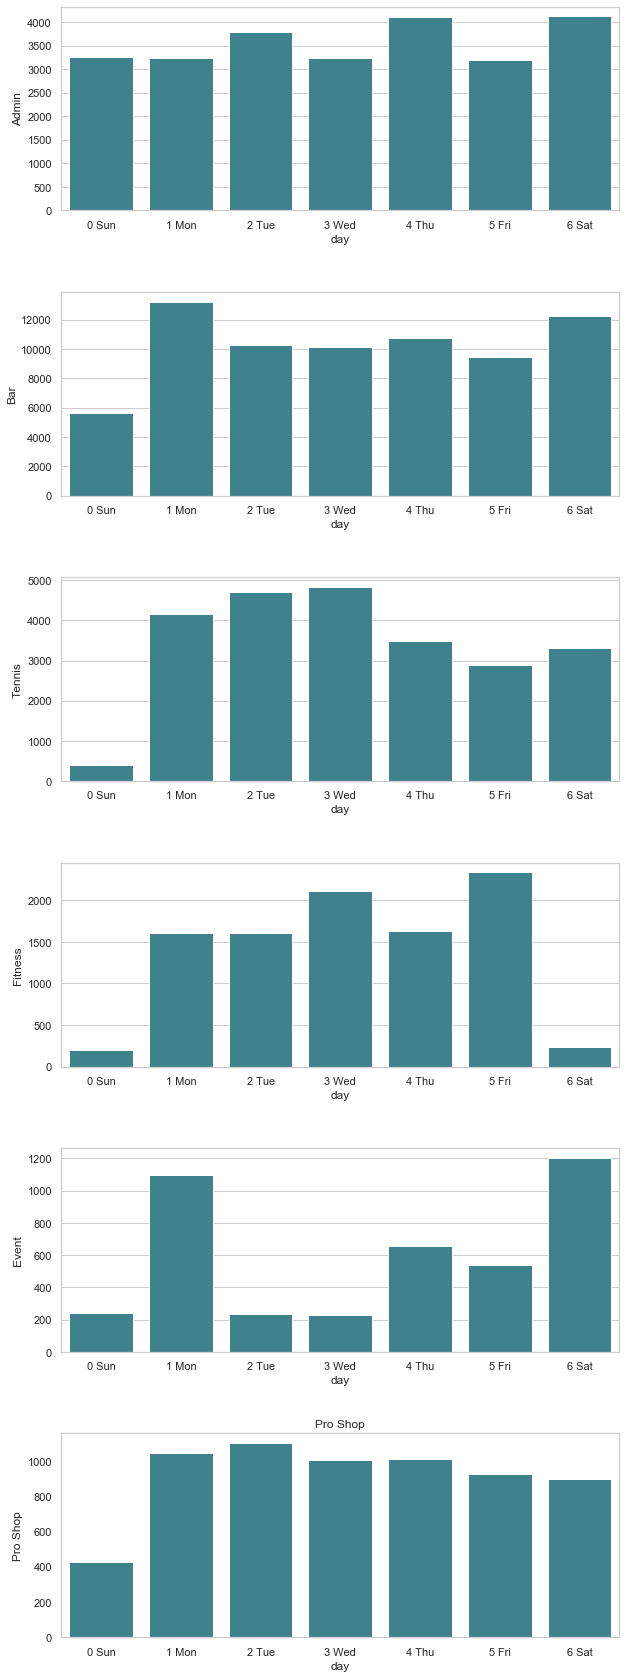

In [98]:
fig,ax=plt.subplots(6,1,figsize=(10,30))

for ix,cat in enumerate(["Admin","Bar","Tennis","Fitness","Event","Pro Shop"]):
    sns.barplot(data=daily_eng,x="day",y=cat,palette=["#328B9B"],ax=ax[ix])
    plt.grid(False)
    plt.title(f"{cat}")
    plt.subplots_adjust(hspace=0.4)
#     plt.savefig(f'graph/daily_eng_{cat}.png', transparent=True)

In [109]:
daily_eng

category  Admin    Bar  Event  Fitness  Pro Shop  Tennis
day                                                     
0 Sun      3258   5667    242      194       429     398
1 Mon      3237  13240   1100     1611      1047    4169
2 Tue      3784  10294    235     1605      1100    4696
3 Wed      3243  10177    226     2111      1002    4829
4 Thu      4112  10744    658     1631      1011    3493
5 Fri      3192   9453    538     2338       923    2880
6 Sat      4124  12274   1204      236       899    3303

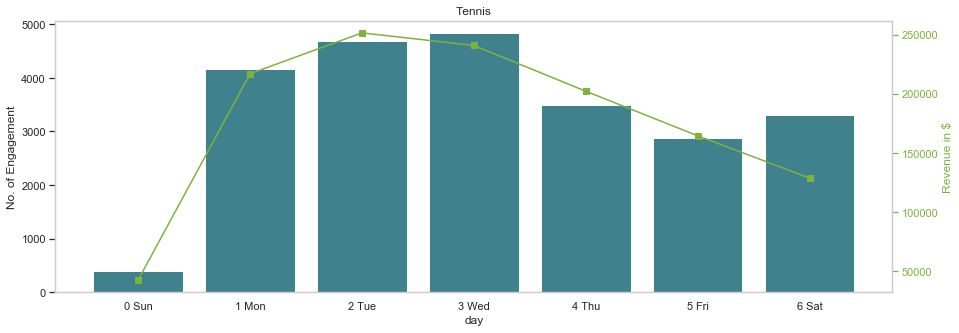

In [122]:
fig, ax1 = plt.subplots(figsize=(15,5))

sns.barplot(data=daily_eng,x="day",y="Tennis",palette=["#328B9B"],ax=ax1)
ax1.grid(False)
ax1.set_ylabel("No. of Engagement")

ax2 = ax1.twinx()
lab2 = ax2.plot(daily_rev.Tennis,color="#7FB13F",marker="s")
ax2.set_ylabel('', color='#7FB13F')
ax2.tick_params('y', colors='#7FB13F')
ax2.grid(False)
ax2.set_ylabel("Revenue in $")


plt.title("Tennis")
# plt.savefig(f'graph/daily_season_tennis.png', transparent=True)

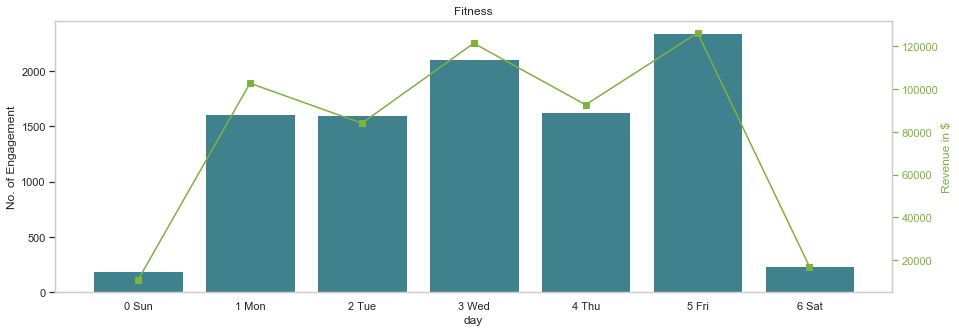

In [123]:
fig, ax1 = plt.subplots(figsize=(15,5))

sns.barplot(data=daily_eng,x="day",y="Fitness",palette=["#328B9B"],ax=ax1)
ax1.grid(False)
ax1.set_ylabel("No. of Engagement")

ax2 = ax1.twinx()
lab2 = ax2.plot(daily_rev.Fitness,color="#7FB13F",marker="s")
ax2.set_ylabel('', color='#7FB13F')
ax2.tick_params('y', colors='#7FB13F')
ax2.grid(False)
ax2.set_ylabel("Revenue in $")

plt.title("Fitness")
# plt.savefig(f'graph/daily_season_fitness.png', transparent=True)

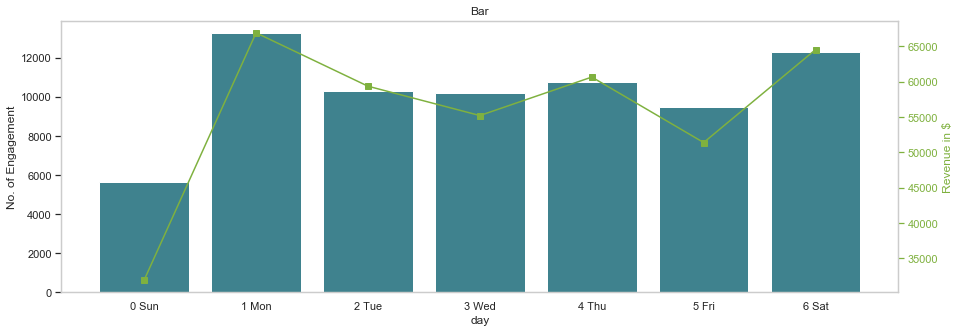

In [124]:
fig, ax1 = plt.subplots(figsize=(15,5))

sns.barplot(data=daily_eng,x="day",y="Bar",palette=["#328B9B"],ax=ax1)
ax1.grid(False)
ax1.set_ylabel("No. of Engagement")

ax2 = ax1.twinx()
lab2 = ax2.plot(daily_rev.Bar,color="#7FB13F",marker="s")
ax2.set_ylabel('', color='#7FB13F')
ax2.tick_params('y', colors='#7FB13F')
ax2.grid(False)
ax2.set_ylabel("Revenue in $")

plt.title("Bar")
# plt.savefig(f'graph/daily_season_bar.png', transparent=True)

In [33]:
admin_daily = dft[dft.category=="Admin"].resample("MS")[["total"]].sum()
bar_daily = dft[dft.category=="Bar"].resample("MS")[["total"]].sum()
tennis_monthly = dft[dft.category=="Tennis"].resample("MS")[["total"]].sum()
fitness_monthly = dft[dft.category=="Fitness"].resample("MS")[["total"]].sum()
event_monthly = dft[dft.category=="Event"].resample("MS")[["total"]].sum()
ps_monthly = dft[dft.category=="Pro Shop"].resample("MS")[["total"]].sum()

acn  trans_id  \
timestamp                             
2015-08-12 16:03:00    11     37777   
2015-08-21 08:02:00    11     38361   
2015-08-21 08:02:00    11     38360   
2015-07-24 11:53:00    11     35130   
2015-07-24 11:53:00    11     35131   
2015-07-24 11:53:00    11     35132   
2015-07-24 11:53:00    11     35139   
2015-07-24 11:53:00    11     35138   
2015-07-24 11:53:00    11     35137   
2015-07-24 11:53:00    11     35136   
2015-07-24 11:53:00    11     35135   
2015-07-24 11:53:00    11     35134   
2015-07-24 11:53:00    11     35133   
2015-11-23 08:38:00    11     50622   
2015-11-14 12:32:00    11     49262   
2015-12-17 13:56:00    11     52993   
2015-12-02 10:09:00    11     51773   
2015-12-12 07:57:00    11     52556   
2015-12-14 15:38:00    11     52704   
2015-12-15 15:47:00    11     52803   
2015-09-10 15:07:00    11     41721   
2015-09-10 15:07:00    11     41720   
2015-10-09 11:05:00    11     44946   
2015-03-27 21:52:00    11     17456   
2015-03-23 13:13:00    11     17047   
2015-03-17 09:44:00    11     16691   
2015-04-17 09:05:00    11     20085   
2015-04-12 16:27:00    11     19657   
2015-04-23 17:01:00    11     21141   
2015-04-21 15:42:00    11     20935   
...                   ...       ...   
2019-12-17 09:32:00  5387    243095   
2019-12-08 12:45:00  5388    242256   
2019-12-04 18:24:00  5391    241933   
2019-12-04 18:22:00  5392    241932   
2019-12-30 19:38:00  5396    244019   
2019-12-30 20:06:00  5396    244026   
2019-12-30 20:09:00  5396    244027   
2019-12-30 20:12:00  5396    244028   
2019-12-30 19:19:00  5396    244008   
2019-12-30 19:19:00  5396    244009   
2019-12-28 16:05:00  5396    243783   
2019-12-28 16:05:00  5396    243782   
2019-12-28 15:30:00  5396    243775   
2019-12-28 15:30:00  5396    243776   
2019-12-28 15:30:00  5396    243777   
2019-12-31 00:00:00  5396    244448   
2019-12-10 14:19:00  5396    242489   
2019-12-10 14:19:00  5396    242488   
2019-12-09 20:45:00  5397    242429   
2019-12-17 17:04:00  5424    243138   
2019-12-28 13:28:00  5425    243751   
2019-12-28 13:28:00  5425    243752   
2019-12-28 13:40:00  5425    243753   
2019-12-28 13:40:00  5425    243754   
2019-12-28 13:43:00  5425    243758   
2019-12-31 00:00:00  5425    244449   
2019-12-20 11:18:00  5425    243309   
2019-12-20 11:18:00  5425    243310   
2019-12-27 15:50:00  5428    243695   
2019-12-31 00:00:00  5428    244450   

                                                                  item  \
timestamp                                                                
2015-08-12 16:03:00                                         Core Power   
2015-08-21 08:02:00                                      Berries Amore   
2015-08-21 08:02:00                                    Smoothie Add-On   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-07-24 11:53:00                                    $2.00 Ice Cream   
2015-11-23 08:38:00                                          CLIFF BAR   
2015-11-14 12:32:00                                         Core Power   
2015-12-17 13:56:00                                      Berries Amore   
2015-12-02 10:09:00                                      Berries Amore   
2015-12-12 07:57:00                                         Core Power   
2015-12-14 15:38:00                                      Berries Amore   
2015-12-15

In [131]:
monthly_rev = dft.pivot_table(columns="category",index="month",values="total",aggfunc="mean").reset_index()
monthly_rev

category         month       Admin       Bar      Event    Fitness   Pro Shop  \
0           01 January  124.827737  5.250123  43.284822  53.771850  27.349388   
1          02 February  134.541674  5.313359  15.441451  54.110822  26.513120   
2             03 March  124.261032  5.232762  51.610977  56.871532  30.600373   
3             04 April  126.702141  5.504186  68.261705  57.925676  27.159162   
4               05 May  124.938890  5.214417  25.519654  55.066038  27.713737   
5              06 June  101.582725  5.076299  20.361839  56.482729  25.453507   
6              07 July  103.783011  5.722379  21.745758  55.885920  24.616057   
7            08 August  108.278979  5.320810  20.195035  60.024610  27.434391   
8         09 September  109.125147  5.470231  34.154508  65.661003  22.550039   
9           10 October  103.728977  5.721360  14.555840  56.550690  20.791281   
10         11 November  106.251200  5.588079  19.255258  57.068957  25.086933   
11         12 December  110.003050  5.951325  21.151801  59.465994  27.952964   

category     Tennis  
0         55.084082  
1         57.094233  
2         53.056343  
3         57.167986  
4         49.062475  
5         49.780137  
6         48.105464  
7         51.353483  
8         51.150346  
9         52.821190  
10        52.457112  
11        52.065301

In [132]:
monthly_eng = dft.pivot_table(columns="category",index="month",values="total",aggfunc="count").reset_index()
monthly_eng

category         month  Admin   Bar  Event  Fitness  Pro Shop  Tennis
0           01 January   1874  4137    562      984       539    2080
1          02 February   1786  3965    255      961       516    1760
2             03 March   1831  5410    430      829       616    2059
3             04 April   1789  6090    258      740       692    2314
4               05 May   1910  7734    549     1007       661    2008
5              06 June   2323  8556    473      579       556    1896
6              07 July   2438  9441    594      875       558    1995
7            08 August   2340  7407    288      833       542    2093
8         09 September   2238  5592    264      618       511    2026
9           10 October   2140  5499    125      870       484    2152
10         11 November   2150  4243    194      786       375    1908
11         12 December   2131  3775    211      644       361    1477

Text(0.5, 1.0, 'Admin')

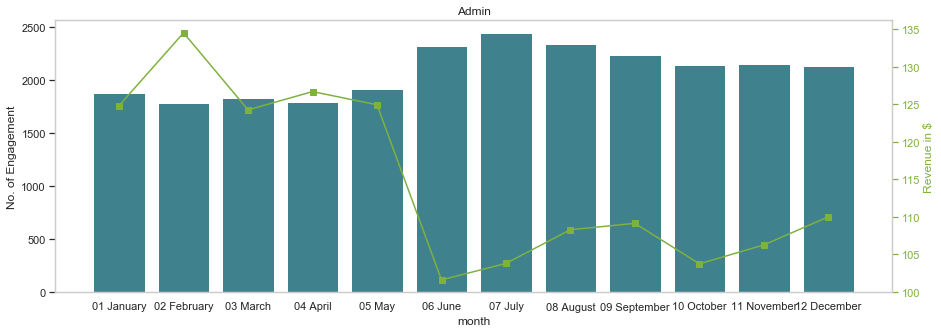

In [134]:
fig, ax1 = plt.subplots(figsize=(15,5))

sns.barplot(data=monthly_eng,x="month",y="Admin",palette=["#328B9B"],ax=ax1)
ax1.grid(False)
ax1.set_ylabel("No. of Engagement")

ax2 = ax1.twinx()
lab2 = ax2.plot(monthly_rev.Admin,color="#7FB13F",marker="s")
ax2.set_ylabel('', color='#7FB13F')
ax2.tick_params('y', colors='#7FB13F')
ax2.grid(False)
ax2.set_ylabel("Revenue in $")

plt.title("Admin")
# plt.savefig(f'graph/daily_season_bar.png', transparent=True)

### Month-per-month Predictability (Autocorrelation Function)
- Admin, Bar - the revenue of present month is very strongly correlated to the month prior at 82%, 88%
- Pro Shop - the revenue of present month is moderately correlated to the month prior at 53%
- Fitness - the revenue of present month is weakly correlated to 3 months prior at 33%
- Tennis, Events - if you want to know what tennis and events revenue will be in the present month, the biggest indication is from 6 months and 11 months ago, respectively. But these relationships are very weak.

In [28]:
for number in range(12):
    print(f"lag month of: {number+1}")
    for df in acf_dfs:
        print(df["total"].autocorr(lag=number+1))
    print(" ")

lag month of: 1
0.8163610915223855
0.8795259940737065
0.19445472229122251
-0.012722497731380834
-0.06287896112584695
0.5256077464905309
 
lag month of: 2
0.7347907764607575
0.7469944057967681
0.04511625471005152
0.04606995567861944
-0.014138421158981673
0.3001423777872231
 
lag month of: 3
0.7177639872831265
0.6149345241996974
0.17288276103824904
0.33276171096241436
-0.021091678713263753
0.19169795651065052
 
lag month of: 4
0.6690537734086701
0.47956638340995256
-0.10900269239648055
-0.05046832384559179
-0.057490285790889065
0.22912441659908403
 
lag month of: 5
0.7583755767745001
0.37779898240346593
0.046939788983979075
-0.025067014458066472
-0.1539784131685455
0.1402906574577119
 
lag month of: 6
0.7541875058920422
0.3497533014016334
0.19375663286352401
0.09159874770685075
-0.00968544879596426
-0.14354631512641952
 
lag month of: 7
0.667879227802567
0.3525967571421347
0.1486810972853362
-0.08961398180698583
-0.10524640636866915
-0.10444005919831374
 
lag month of: 8
0.66287195211397

# Modeling

In [29]:
d = dft.copy()
d = d.rename(columns={"total":"y"})
d.index = d.index.rename("ds")

In [30]:
d.head()

acn  trans_id             item          item_group     y  \
ds                                                                              
2015-08-12 16:03:00   11     37777       Core Power            Beverage  2.80   
2015-08-21 08:02:00   11     38361    Berries Amore            Beverage  4.28   
2015-08-21 08:02:00   11     38360  Smoothie Add-On            Beverage  0.67   
2015-07-24 11:53:00   11     35130  $2.00 Ice Cream  Food & Consumables  2.00   
2015-07-24 11:53:00   11     35131  $2.00 Ice Cream  Food & Consumables  2.00   

                           membership group city state  zipcode  lat  long  \
ds                                                                           
2015-08-12 16:03:00  Misc. Membership   NaN  NaN   NaN      NaN  NaN   NaN   
2015-08-21 08:02:00  Misc. Membership   NaN  NaN   NaN      NaN  NaN   NaN   
2015-08-21 08:02:00  Misc. Membership   NaN  NaN   NaN      NaN  NaN   NaN   
2015-07-24 11:53:00  Misc. Membership   NaN  NaN   NaN      NaN  NaN   NaN   
2015-07-24 11:53:00  Misc. Membership   NaN  NaN   NaN      NaN  NaN   NaN   

                    category    day  year      month  
ds                                                    
2015-08-12 16:03:00      Bar  3 Wed  2015  08 August  
2015-08-21 08:02:00      Bar  5 Fri  2015  08 August  
2015-08-21 08:02:00      Bar  5 Fri  2015  08 August  
2015-07-24 11:53:00      Bar  5 Fri  2015    07 July  
2015-07-24 11:53:00      Bar  5 Fri  2015    07 July

In [31]:
dfbar = d[d.category == "Bar"].resample("D").sum()[["y"]].reset_index()
dfps = d[d.category == "Pro Shop"].resample("D").sum()[["y"]].reset_index()
dftennis = d[d.category == "Tennis"].resample("D").sum()[["y"]].reset_index()
dfadmin = d[d.category == "Admin"].resample("D").sum()[["y"]].reset_index()
dffitness = d[d.category == "Fitness"].resample("D").sum()[["y"]].reset_index()
dfevent = d[d.category == "Event"].resample("D").sum()[["y"]].reset_index()

In [32]:
dfbar

ds       y
0    2015-01-02    8.51
1    2015-01-03   32.37
2    2015-01-04   51.41
3    2015-01-05   35.35
4    2015-01-06  131.36
5    2015-01-07   50.31
6    2015-01-08   47.50
7    2015-01-09   10.00
8    2015-01-10   25.35
9    2015-01-11    4.25
10   2015-01-12   38.71
11   2015-01-13   54.31
12   2015-01-14   55.48
13   2015-01-15   28.01
14   2015-01-16  387.22
15   2015-01-17   38.75
16   2015-01-18    2.75
17   2015-01-19   39.89
18   2015-01-20  339.16
19   2015-01-21   29.25
20   2015-01-22   31.15
21   2015-01-23  105.69
22   2015-01-24   48.75
23   2015-01-25   16.80
24   2015-01-26   26.01
25   2015-01-27  368.34
26   2015-01-28   21.00
27   2015-01-29   34.66
28   2015-01-30   68.85
29   2015-01-31   35.44
...         ...     ...
1795 2019-12-02  283.31
1796 2019-12-03  233.66
1797 2019-12-04  417.41
1798 2019-12-05  375.72
1799 2019-12-06  168.64
1800 2019-12-07  912.97
1801 2019-12-08   16.98
1802 2019-12-09  883.13
1803 2019-12-10  232.22
1804 2019-12-11  293.35
1805 2019-12-12  237.42
1806 2019-12-13  157.69
1807 2019-12-14  220.49
1808 2019-12-15   11.33
1809 2019-12-16  341.75
1810 2019-12-17  210.76
1811 2019-12-18  326.16
1812 2019-12-19  458.00
1813 2019-12-20   73.48
1814 2019-12-21  278.37
1815 2019-12-22   86.76
1816 2019-12-23  487.84
1817 2019-12-24  132.45
1818 2019-12-25    0.00
1819 2019-12-26  238.01
1820 2019-12-27  204.73
1821 2019-12-28  326.71
1822 2019-12-29   81.99
1823 2019-12-30  978.50
1824 2019-12-31  408.63

[1825 rows x 2 columns]